In [1]:
import pandas as pd
import numpy as np
import torch as pt
from scipy.linalg import qr
import matplotlib.pyplot as plt
import princo_ml as pml

pt.set_default_tensor_type('torch.FloatTensor')
#pt.set_default_tensor_type('torch.cuda.FloatTensor')

In [2]:
from princo_ml.controllers.Controller import Controller as Control
from princo_ml.clusters import DataCluster as Data, LearnCluster as Learn
from princo_ml.utils.learn_modules.learners import GradientLearner, NewtonLearner, MomentumLearner, SmoothLearner
from princo_ml.utils.learn_modules.activators import LinearActivator, SigmoidActivator, TanhActivator, ReluActivator
from princo_ml.utils.losses.CrossEntLoss import CrossEntLoss
from princo_ml.utils.learn_modules.DenseHingeModule import DenseHingeModule

In [3]:
dataset = pd.get_dummies(pd.read_csv('data_files/titanic_train.csv', index_col = 'PassengerId'), dummy_na = True, columns = ['Sex', 'Pclass', 'Embarked'])
test_dataset = pd.get_dummies(pd.read_csv('data_files/titanic_test.csv', index_col = 'PassengerId'), dummy_na = True, columns = ['Sex', 'Pclass', 'Embarked'])

dataset['sex_mean'] = 0.
test_dataset['sex_mean'] = 0.
dataset.loc[dataset['Sex_female'] == 1, 'sex_mean'] = dataset['Sex_female'].mean()
dataset.loc[dataset['Sex_male'] == 1, 'sex_mean'] = dataset['Sex_male'].mean()
test_dataset.loc[test_dataset['Sex_female'] == 1, 'sex_mean'] = dataset['Sex_female'].mean()
test_dataset.loc[test_dataset['Sex_male'] == 1, 'sex_mean'] = dataset['Sex_male'].mean()

feature_cols = [col for col in dataset.columns if col not in ('Name', 'Ticket', 'Cabin', 'Survived', 'Age')]
target_cols = ['Survived']
dataset.fillna(0, inplace = True)

In [4]:
verbose = False

learner = SmoothLearner
learn_rate_kwargs = {
    'seed_learn': 1e-1
}

loss = CrossEntLoss
loss_kwargs = {
    'mean': True
}

activator = ReluActivator
activator_kwargs = {
    'leak': 0.05
}

batcher_kwargs = {
    'proportion': 1.0
}

hinger = DenseHingeModule
hinges = 5

control = Control('regression_controller')

control.add_cluster(
    Data(
        'data_cluster',
        dataset[feature_cols + target_cols],
        splitter_kwargs = {'verbose': verbose},
        batcher_kwargs = {'verbose': verbose, **batcher_kwargs},
        loss = loss, loss_kwargs = {'verbose': verbose, **loss_kwargs},
        loss_combiner_kwargs = {'verbose': verbose},
        verbose = verbose
    )
)
"""
control.link_add(
    Learn(
        'learn_cluster_1',
        module_kwargs = {
            'nodes': 1,
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_add(
    Learn(
        'learn_cluster_1a',
        module = hinger,
        module_kwargs = {
            'nodes': 1,
            'hinges': hinges,
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = ['Fare']
)

control.link_add(
    Learn(
        'learn_cluster_1b',
        module_kwargs = {
            'nodes': 1,
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'data_cluster', 'input', data_cols = [col for col in feature_cols if col != 'Fare']
)

control.link_add(
    Learn(
        'learn_cluster_2',
        module_kwargs = {
            'nodes': 32,
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': activator, 'activator_kwargs': {'verbose': verbose, **activator_kwargs},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    'learn_cluster_1a', 'input'
    #'learn_cluster_1', 'input'
)
control.link_clusters('learn_cluster_1b', 'learn_cluster_2')
"""
control.link_add(
    Learn(
        'learn_cluster_out',
        module_kwargs = {
            'nodes': len(target_cols),
            'verbose': verbose,
            'bias_init_kwargs': {'verbose': verbose},
            'weight_init_kwargs': {'verbose': verbose},
            'combiner_kwargs': {'verbose': verbose},
            'activator': SigmoidActivator, 'activator_kwargs': {'verbose': verbose},
            'learner': learner, 'learner_kwargs': {'verbose': verbose},
            'learn_rate_kwargs': {'verbose': verbose, **learn_rate_kwargs}
        },
        verbose = verbose
    ),
    #'learn_cluster_2', 'input'
    'data_cluster', 'input', data_cols = feature_cols
)

control.link_clusters('learn_cluster_out', 'data_cluster', data_cols = target_cols)

control.enable_network()

In [5]:
control.train_model(10000)

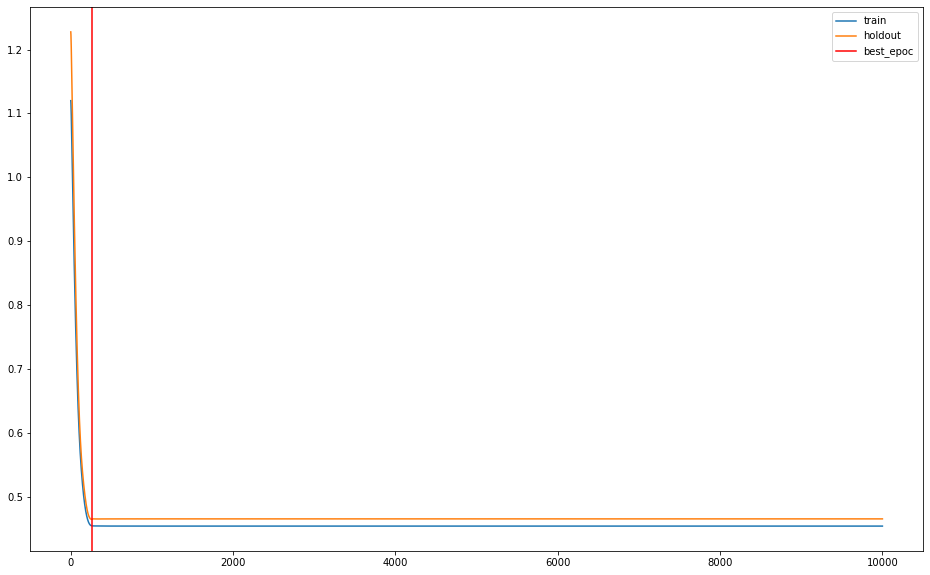

In [6]:
control.plot_losses()